# TMLE Example Notebook

This notebook demonstrates the issue of using uplift curves without knowing true treatment effect and how to solve it by using TMLE as a proxy of the true treatment effect.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import logging
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
import sys
import warnings
warnings.simplefilter("ignore", UserWarning)

from lightgbm import LGBMRegressor

In [3]:
import causalml

from causalml.dataset import synthetic_data
from causalml.inference.meta import BaseXRegressor, TMLELearner
from causalml.metrics.visualize import plot
from causalml.propensity import calibrate

print(causalml.__version__)

0.7.0


/Users/jeong/.conda/envs/py36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [4]:
logger = logging.getLogger('causalml')
logger.setLevel(logging.DEBUG)
plt.style.use('fivethirtyeight')

## Generating Synthetic Data

In [5]:
# Generate synthetic data using mode 1
y, X, treatment, tau, b, e = synthetic_data(mode=1, n=1000000, p=10, sigma=5.)

In [6]:
X_train, X_test, y_train, y_test, e_train, e_test, treatment_train, treatment_test, tau_train, tau_test, b_train, b_test = train_test_split(X, y, e, treatment, tau, b, test_size=0.5, random_state=42)

## Calculating Individual Treatment Effect (ITE/CATE)

In [7]:
# X Learner
learner_x = BaseXRegressor(learner=LGBMRegressor())
learner_x.fit(X=X_train, treatment=treatment_train, y=y_train)
cate_x_test = learner_x.predict(X=X_test, p=e_test, treatment=treatment_test).flatten()

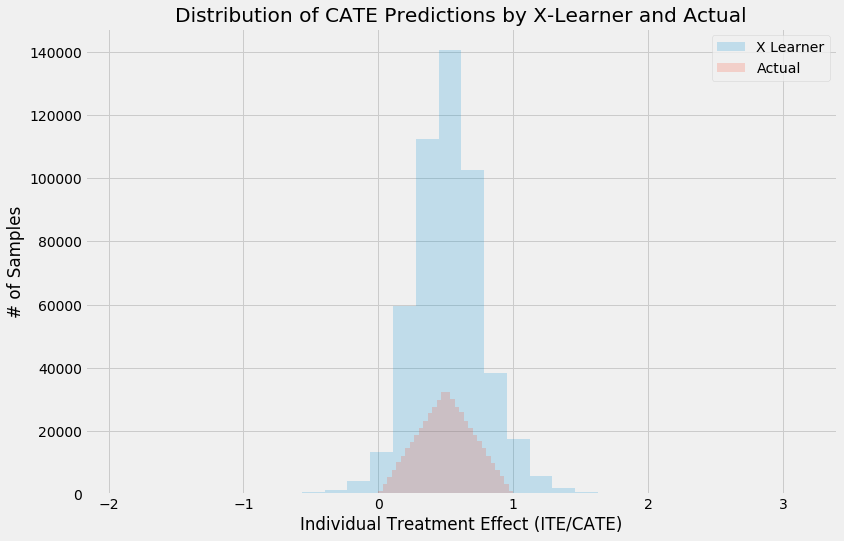

In [8]:
alpha=0.2
bins=30
plt.figure(figsize=(12,8))
plt.hist(cate_x_test, alpha=alpha, bins=bins, label='X Learner')
plt.hist(tau_test, alpha=alpha, bins=bins, label='Actual')

plt.title('Distribution of CATE Predictions by X-Learner and Actual')
plt.xlabel('Individual Treatment Effect (ITE/CATE)')
plt.ylabel('# of Samples')
_=plt.legend()

## Validating CATE without TMLE

In [9]:
df = pd.DataFrame({'y': y_test, 'w': treatment_test, 'tau': tau_test, 'X-Learner': cate_x_test, 'Actual': tau_test})

### Uplift Curve With Ground Truth

If true treatment effect is known as in simulations, the uplift curve of a model uses the cumulative sum of the treatment effect sorted by model's CATE estimate.

In the figure below, the uplift curve of X-learner shows positive lift close to the optimal lift by the ground truth.

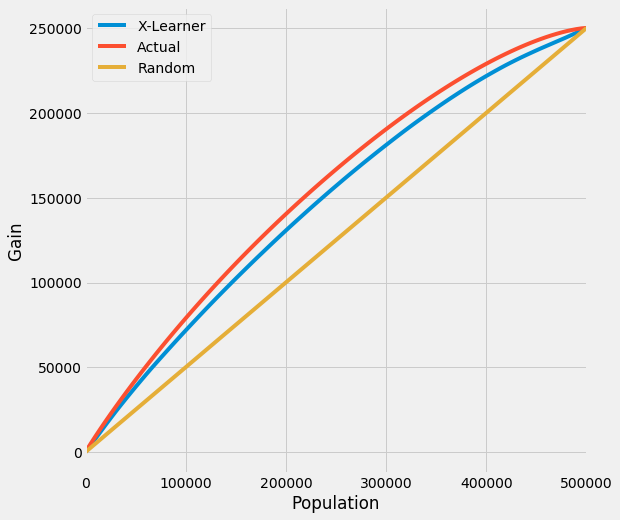

In [10]:
plot(df, outcome_col='y', treatment_col='w', treatment_effect_col='tau')

### Uplift Curve Without Ground Truth

If true treatment effect is unknown as in practice, the uplift curve of a model uses the cumulative mean difference of outcome in the treatment and control group sorted by model's CATE estimate.

In the figure below, the uplift curves of X-learner as well as the ground truth show no lift incorrectly.

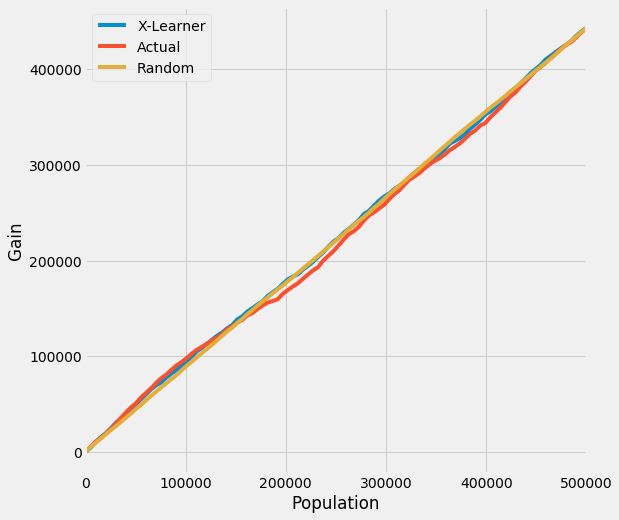

In [11]:
plot(df.drop('tau', axis=1), outcome_col='y', treatment_col='w')

## TMLE 

In [12]:
n_fold = 5
n_segment = 5

### TMLE Model Training

In [13]:
kf = KFold(n_splits=n_fold)

In [14]:
tmle = TMLELearner(learner=LGBMRegressor(num_leaves=64, learning_rate=.05, n_estimators=300), 
                   cv=kf, calibrate_propensity=True)

ate_all, ate_all_lb, ate_all_ub = tmle.estimate_ate(X=X_test, p=e_test, treatment=treatment_test, y=y_test)

ate_all, ate_all_lb, ate_all_ub

(array([0.48519038]), array([0.44700673]), array([0.52337404]))

In [15]:
tmle = TMLELearner(learner=LGBMRegressor(num_leaves=64, learning_rate=.05, n_estimators=300), 
                   cv=kf, calibrate_propensity=True)

ate_actual, ate_actual_lb, ate_actual_ub = tmle.estimate_ate(X=X_test, p=e_test, treatment=treatment_test, y=y_test, segment=pd.qcut(tau_test, n_segment, labels=False))

ate_actual, ate_actual_lb, ate_actual_ub

(array([[0.23832289, 0.31886538, 0.49245553, 0.62525711, 0.74732071]]),
 array([[0.14385232, 0.24425482, 0.42198478, 0.53504789, 0.65116524]]),
 array([[0.33279346, 0.39347594, 0.56292628, 0.71546634, 0.84347617]]))

In [16]:
tmle = TMLELearner(learner=LGBMRegressor(num_leaves=64, learning_rate=.05, n_estimators=300), 
                   cv=kf, calibrate_propensity=True)

ate_xlearner, ate_xlearner_lb, ate_xlearner_ub = tmle.estimate_ate(X=X_test, p=e_test, treatment=treatment_test, y=y_test, segment=pd.qcut(cate_x_test, n_segment, labels=False))

ate_xlearner, ate_xlearner_lb, ate_xlearner_ub

(array([[0.25054712, 0.3684493 , 0.47452339, 0.61840324, 0.70596878]]),
 array([[0.15971414, 0.2884313 , 0.39486034, 0.53051316, 0.61611653]]),
 array([[0.34138009, 0.4484673 , 0.55418644, 0.70629331, 0.79582103]]))

### Uplift Curve with TMLE as Ground Truth

By using TMLE as a proxy of the ground truth, the uplift curves of X-learner and the ground truth become close to the original using the ground truth.

Text(0, 0.5, 'Lift in GB')

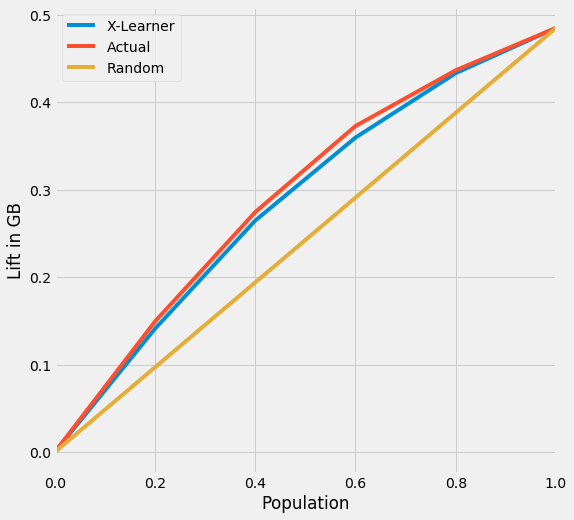

In [17]:
lift_actual = [0.] * (n_segment + 1)
lift_actual[n_segment] = ate_all[0]

lift_xlearner = [0.] * (n_segment + 1)
lift_xlearner[n_segment] = ate_all[0]

for i in range(1, n_segment):
    lift_actual[i] = ate_actual[0][n_segment - i] * .2 + lift_actual[i - 1]
    lift_xlearner[i] = ate_xlearner[0][n_segment - i] * .2 + lift_xlearner[i - 1]     

pd.DataFrame({'Population': np.linspace(0, 1, n_segment + 1),
              'Actual': lift_actual,
              'X-Learner': lift_xlearner,
              'Random': np.linspace(0, 1, n_segment + 1)*lift_actual[-1]}).plot(x='Population', 
                                                                                y=['X-Learner', 'Actual', 'Random'], 
                                                                                figsize=(8, 8))
plt.ylabel('Lift in GB')